# EEL891 - 2023.02 - Trabalho 2

Este trabalho envolve utilizar técnicas de regrssão para estimar o preço de um imóvel a partir de suas características.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

from xgboost import XGBRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.linear_model import BayesianRidge, Ridge, OrthogonalMatchingPursuit
from sklearn.ensemble import GradientBoostingRegressor


## 1. Lendo e organizando dados

Aqui estou lendo os dados de teste e treinamento dos arquivos csv e depois juntando-os em um só arquivo "imovel_df" para que possamos fazer o pré-processamento de uma vez só.

"split_index" é uma variável para guardar o ponto de junção dos conjuntos de dados (corresponde ao primeiro índice de 'imovel_df' que faz parte do test set) para que depois eles possam ser separados de novo. "Id" guarda os IDs dos imóveis que terão seu campo 'preco' previsto pelo modelo; estes IDs farão parte do arquivo de saída que será enviado ao Kaggle e foram separados para facilitar.

In [3]:
train = pd.read_csv('conjunto_de_treinamento.csv')
test = pd.read_csv('conjunto_de_teste.csv')

In [4]:
# Salvar os Ids para auxiliar na criação do arquivo que será enviado ao Kaggle
id = test['Id']

# Criando um DF novo com o train e o test
imovel_df = pd.concat([train, test], ignore_index=True)

In [5]:
# Para auxiliar no momento separar o DF credito_df em train e test
split_index = len(train)

In [6]:
imovel_df

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,...,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
0,2000,Casa,Imbiribeira,Imobiliaria,3,3,5,223,167,piscina e copa,...,0,1,0,0,0,0,0,0,0,1000000.0
1,2001,Apartamento,Casa Amarela,Imobiliaria,4,4,2,157,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,680000.0
2,2002,Apartamento,Encruzilhada,Imobiliaria,3,1,0,53,0,nenhum,...,0,0,0,0,0,0,0,0,0,450000.0
3,2003,Apartamento,Boa Viagem,Imobiliaria,4,3,2,149,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,1080000.0
4,2004,Apartamento,Rosarinho,Imobiliaria,2,1,1,54,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,350000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6678,1995,Apartamento,Poco da Panela,Imobiliaria,2,1,2,100,0,nenhum,...,0,0,0,0,0,0,0,0,0,NaN
6679,1996,Apartamento,Madalena,Imobiliaria,3,1,1,90,0,nenhum,...,0,0,0,0,0,0,0,0,0,NaN
6680,1997,Apartamento,Boa Viagem,Imobiliaria,3,1,1,73,0,piscina e salao de festas,...,0,1,0,0,1,0,0,0,0,NaN
6681,1998,Apartamento,Torre,Imobiliaria,4,3,2,112,2810,piscina e frente para o mar,...,0,1,0,0,0,0,0,0,1,NaN


## 2. Preparação dos dados
Análise e preparação dos dados para treinamento

### 2.1. Valores Nulos
Antes de tudo, é fundamental lidar com valores ausentes no conjunto de dados. Aqui, vemos que todas as colunas estão preenchidas e não há nulos.

In [7]:
imovel_df.isnull().sum()

Id                   0
tipo                 0
bairro               0
tipo_vendedor        0
quartos              0
suites               0
vagas                0
area_util            0
area_extra           0
diferenciais         0
churrasqueira        0
estacionamento       0
piscina              0
playground           0
quadra               0
s_festas             0
s_jogos              0
s_ginastica          0
sauna                0
vista_mar            0
preco             2000
dtype: int64

### 2.2. Modificação de Features
Aqui fiz uma breve análise das features que temos, vendo quais seus valores e gerando alguns gráficos para ver como elas se relacionam com nossa coluna de alvo (preço). Assim, tentei 'otimizar' algumas features para melhores previsões. Variáveis categóricas que continham muitos valores diferentes como suites, vagas e quartos não são tão expressivas dessa forma, e podem ser revelar mais significado quando agrupadas em categorias mais abrangentes; por exemplo, quartos poderia ser subdividido em 'menos que 4 quartos', 'entre 4 e 6 quartos' e '7 ou mais quartos'.

In [8]:
def analysis(data, column, target='preco'):
    print(f'Number of Unique Values: {data[column].nunique()}')
    print(f'\nUnique Values: {data[column].unique()}')
    print(f'\nNumber of Null Values: {data[column].isnull().sum()}')

    sns.displot(data[column], kde=True)

    # Gráfico de barras com desvio padrão
    sns.barplot(x=column, y=target, data=data, hue=column)
    plt.xlabel(column)
    plt.ylabel(target)
    plt.title(f'{column} x {target}')
    plt.show()


Number of Unique Values: 4

Unique Values: ['Casa' 'Apartamento' 'Quitinete' 'Loft']

Number of Null Values: 0


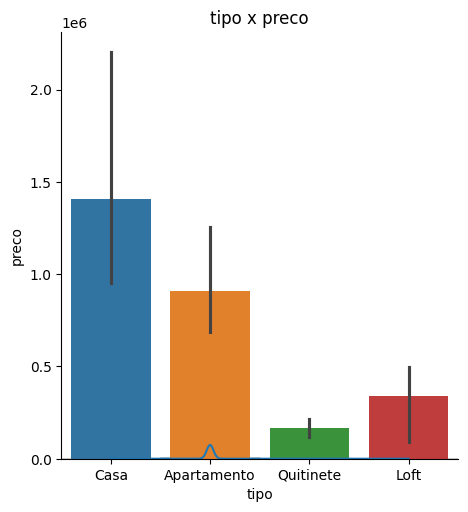

In [9]:
analysis(imovel_df, 'tipo')

Number of Unique Values: 2

Unique Values: ['Imobiliaria' 'Pessoa Fisica']

Number of Null Values: 0


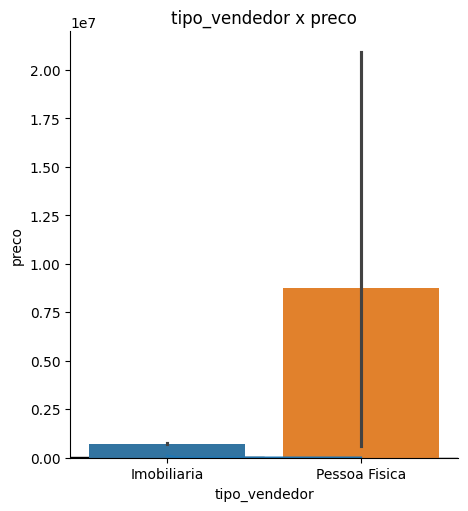

In [10]:
analysis(imovel_df, 'tipo_vendedor')

Number of Unique Values: 10

Unique Values: [ 3  4  2  1  5  6  7  8  9 10]

Number of Null Values: 0


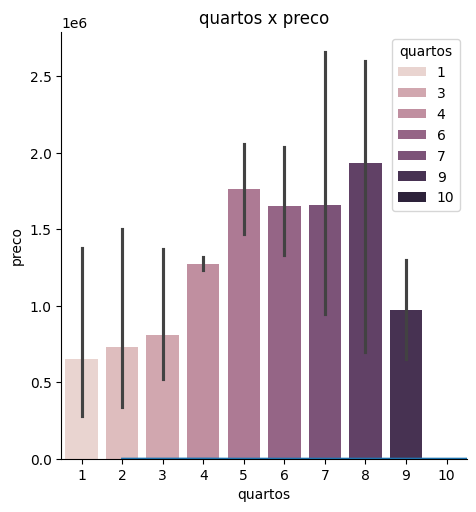

In [11]:
analysis(imovel_df, 'quartos')

In [12]:
# Criando os intervalos e rótulos para as novas categorias de quartos
intervalos = [0, 3, 6, 9]
rotulos = ['0_to_3', '4_to_6', '7_to_9']
imovel_df['quartos'] = pd.cut(imovel_df['quartos'], bins=intervalos, labels=rotulos, include_lowest=True)

imovel_df.head()

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,...,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
0,2000,Casa,Imbiribeira,Imobiliaria,0_to_3,3,5,223,167,piscina e copa,...,0,1,0,0,0,0,0,0,0,1000000.0
1,2001,Apartamento,Casa Amarela,Imobiliaria,4_to_6,4,2,157,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,680000.0
2,2002,Apartamento,Encruzilhada,Imobiliaria,0_to_3,1,0,53,0,nenhum,...,0,0,0,0,0,0,0,0,0,450000.0
3,2003,Apartamento,Boa Viagem,Imobiliaria,4_to_6,3,2,149,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,1080000.0
4,2004,Apartamento,Rosarinho,Imobiliaria,0_to_3,1,1,54,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,350000.0


Number of Unique Values: 7

Unique Values: [3 4 1 0 2 5 6]

Number of Null Values: 0


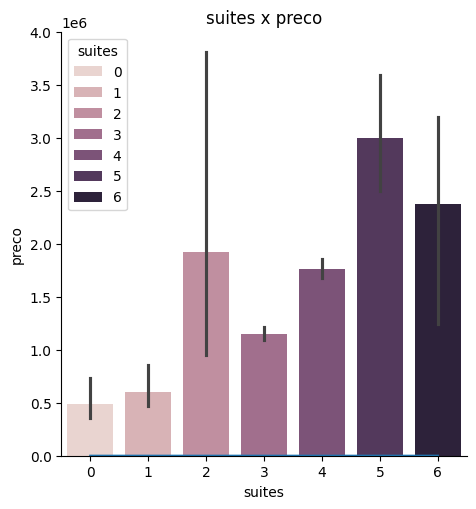

In [13]:
analysis(imovel_df, 'suites')

In [14]:
# Criando os intervalos e rótulos para as novas categorias de suites
intervalos = [0, 1, 4, 6]
rotulos = ['0_to_1', '2_to_4', '5_to_6']
imovel_df['suites'] = pd.cut(imovel_df['suites'], bins=intervalos, labels=rotulos, include_lowest=True)

imovel_df.head()

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,...,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
0,2000,Casa,Imbiribeira,Imobiliaria,0_to_3,2_to_4,5,223,167,piscina e copa,...,0,1,0,0,0,0,0,0,0,1000000.0
1,2001,Apartamento,Casa Amarela,Imobiliaria,4_to_6,2_to_4,2,157,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,680000.0
2,2002,Apartamento,Encruzilhada,Imobiliaria,0_to_3,0_to_1,0,53,0,nenhum,...,0,0,0,0,0,0,0,0,0,450000.0
3,2003,Apartamento,Boa Viagem,Imobiliaria,4_to_6,2_to_4,2,149,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,1080000.0
4,2004,Apartamento,Rosarinho,Imobiliaria,0_to_3,0_to_1,1,54,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,350000.0


Number of Unique Values: 17

Unique Values: [ 5  2  0  1  3  4  6  8 10  7 20 18 12 17 13 15 30]

Number of Null Values: 0


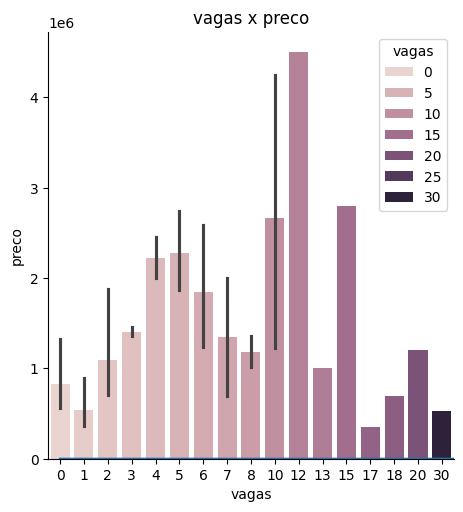

In [15]:
analysis(imovel_df, 'vagas')

In [16]:
# Criando os intervalos e rótulos para as novas categorias de vagas
intervalos = [0, 1, 3, 6, 8, 30]
rotulos = ['0_to_1', '2_to_3', '4_to_6', '7_to_8', 'more_than_9']
imovel_df['vagas'] = pd.cut(imovel_df['vagas'], bins=intervalos, labels=rotulos, include_lowest=True)

imovel_df.head()

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,...,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
0,2000,Casa,Imbiribeira,Imobiliaria,0_to_3,2_to_4,4_to_6,223,167,piscina e copa,...,0,1,0,0,0,0,0,0,0,1000000.0
1,2001,Apartamento,Casa Amarela,Imobiliaria,4_to_6,2_to_4,2_to_3,157,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,680000.0
2,2002,Apartamento,Encruzilhada,Imobiliaria,0_to_3,0_to_1,0_to_1,53,0,nenhum,...,0,0,0,0,0,0,0,0,0,450000.0
3,2003,Apartamento,Boa Viagem,Imobiliaria,4_to_6,2_to_4,2_to_3,149,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,1080000.0
4,2004,Apartamento,Rosarinho,Imobiliaria,0_to_3,0_to_1,0_to_1,54,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,350000.0


Number of Unique Values: 2

Unique Values: [0 1]

Number of Null Values: 0


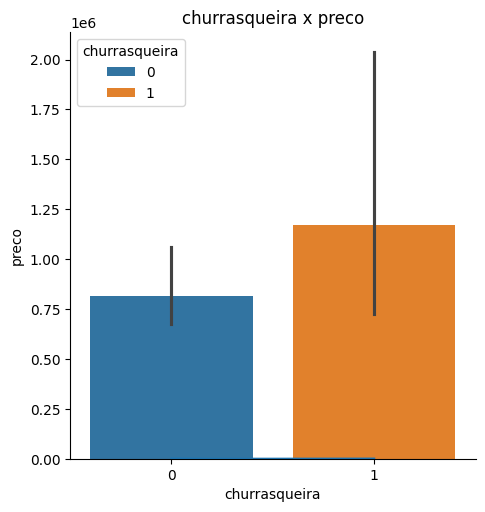

In [17]:
analysis(imovel_df, 'churrasqueira')

Number of Unique Values: 2

Unique Values: [1 0]

Number of Null Values: 0


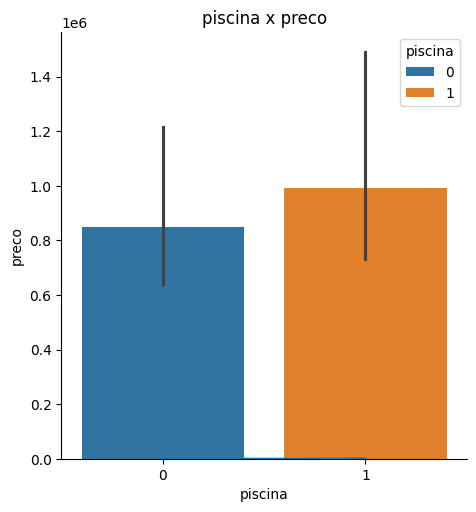

In [18]:
analysis(imovel_df, 'piscina')

Number of Unique Values: 2

Unique Values: [0 1]

Number of Null Values: 0


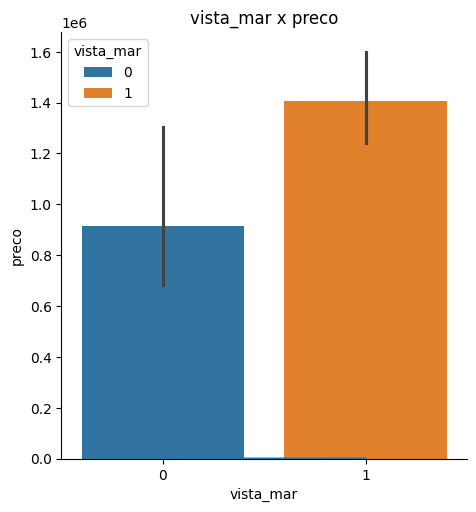

In [19]:
analysis(imovel_df, 'vista_mar')

#### 2.1.1 Diferenciais
Os diferenciais parececem ser, em sua maioria, características já contempladas nos outros campos, mas com menor capacidade analítica. Então, resolvi remover essa coluna. As outras todas manti já que não vejo motivo para fazer muita seleção aqui onde temos poucos campos, todos com informações que julgo relevantes.

In [20]:
imovel_df['diferenciais'].unique()

array(['piscina e copa', 'piscina e churrasqueira', 'nenhum',
       'playground', 'piscina e playground', 'sauna e playground',
       'piscina e sauna', 'piscina e quadra poliesportiva',
       'salao de festas', 'campo de futebol e playground',
       'piscina e estacionamento visitantes', 'copa e salao de festas',
       'esquina e salao de festas', 'piscina e salao de festas',
       'playground e sala de ginastica', 'copa e playground',
       'estacionamento visitantes e playground',
       'playground e salao de festas', 'churrasqueira e playground',
       'churrasqueira e copa', 'churrasqueira e salao de festas', 'copa',
       'esquina', 'piscina', 'playground e quadra poliesportiva',
       'estacionamento visitantes', 'piscina e esquina', 'copa e esquina',
       'estacionamento visitantes e salao de festas',
       'piscina e campo de futebol',
       'frente para o mar e salao de festas', 'churrasqueira',
       'churrasqueira e campo de futebol', 'piscina e frente para 

In [21]:
imovel_df = imovel_df.drop(columns='diferenciais')

### 2.3. Transformação de Features
Alguns modelos funcionam melhor quando os dados com os quais estão lidando tem distribuição normal. Assim, resolvi aplicar uma transformação logaritmica nas variáveis ​​numericas para normalizá-las. A skew acima de +- 0,5 é considerada dados distorcidos (skewed), necessitando de normalização, o que é o caso pra ambas as variáveis não-categóricas que temos.

In [22]:
scipy.stats.skew(imovel_df['area_util'])

7.179728578419954

In [23]:
scipy.stats.skew(imovel_df['area_extra'])

48.87635015609393

In [24]:
imovel_df['area_util'] = np.log1p(imovel_df['area_util'])  # log1p = log(x + 1); pra evitar algum log(0), que e indefinido
imovel_df['area_extra'] = np.log1p(imovel_df['area_extra'])  

### 2.3. Codificação de Variáveis Categóricas
Aqui convertemos variáveis categóricas em representações binárias, criando colunas one-hot, para que possam ser usadas nos algoritmos de machine learning.


In [25]:
imovel_df.columns

Index(['Id', 'tipo', 'bairro', 'tipo_vendedor', 'quartos', 'suites', 'vagas',
       'area_util', 'area_extra', 'churrasqueira', 'estacionamento', 'piscina',
       'playground', 'quadra', 's_festas', 's_jogos', 's_ginastica', 'sauna',
       'vista_mar', 'preco'],
      dtype='object')

In [26]:
categorical_variables = ['tipo', 'bairro', 'tipo_vendedor', 'quartos', 'suites', 'vagas',
       'churrasqueira', 'estacionamento', 'piscina', 'playground', 'quadra', 's_festas', 
       's_jogos', 's_ginastica', 'sauna', 'vista_mar']

In [27]:
# drop_first tira a primeira coluna, de forma que se as outras são zero, ela é a 'selecionada'
for variable in categorical_variables:
    imovel_df = pd.get_dummies(imovel_df, columns=[variable], prefix=[variable], drop_first = True)

### 2.4. Normalização/Padronização
Normalizando as colunas numéricas para garantir que as features tenham escalas comparáveis.

In [28]:
normalize_data = ['area_util', 'area_extra']
scaler = StandardScaler() 

# Aplicar a normalização aos dados
imovel_df[normalize_data] = scaler.fit_transform(imovel_df[normalize_data])

In [29]:
imovel_df

,Id,area_util,area_extra,preco,tipo_Casa,tipo_Loft,tipo_Quitinete,bairro_Afogados,bairro_Agua Fria,bairro_Apipucos,...,churrasqueira_1,estacionamento_1,piscina_1,playground_1,quadra_1,s_festas_1,s_jogos_1,s_ginastica_1,sauna_1,vista_mar_1
0,2000,1.338041,3.701424,1000000.0,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,2001,0.724494,-0.343945,680000.0,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,False
2,2002,-1.162653,-0.343945,450000.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2003,0.633161,-0.343945,1080000.0,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,False
4,2004,-1.130400,-0.343945,350000.0,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6678,1995,-0.062057,-0.343945,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6679,1996,-0.245323,-0.343945,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6680,1997,-0.608817,-0.343945,NaN,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
6681,1998,0.135281,5.925706,NaN,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True


### 2.4. Dividir os dados de novo
Redividindo os dados em conjunto de treinamento e testes. Vou usar todas as colunas que restaram para o treinamento, menos obviamente o id.

In [30]:
imovel_df = imovel_df.drop(columns='Id')

In [31]:
train = imovel_df[:split_index].copy()
test = imovel_df[split_index:].copy()

In [32]:
train = imovel_df[:split_index].copy()
test = imovel_df[split_index:].copy()

In [33]:
X_train = train.drop('preco', axis = 1)
y_train = train['preco']
X_test = test.drop('preco', axis = 1)

# 6. Transformação da variável-alvo
Também apliquei uma transformação logaritmica na variável-alvo (preço), separadamente aqui pra não confundir. É claro que, como as previsões agora vão ser feitas em cima do log dessa variável, os dados vão ter que ser tranformados de volta depois!

<Axes: >

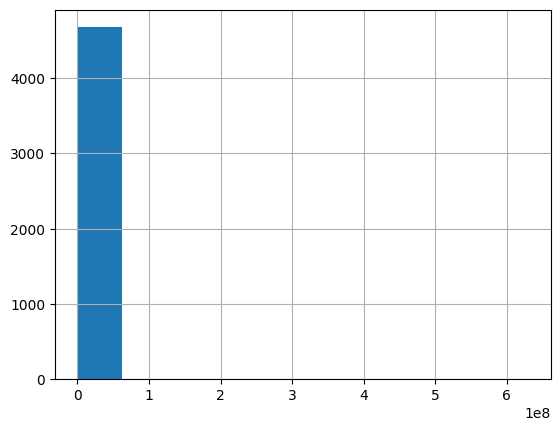

In [34]:
y_train.hist()

C:\Users\Barbara\AppData\Local\Temp\ipykernel_11880\2476867408.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, kde = True, fit = scipy.stats.norm)
C:\Users\Barbara\AppData\Local\Temp\ipykernel_11880\2476867408.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(y_train), kde 

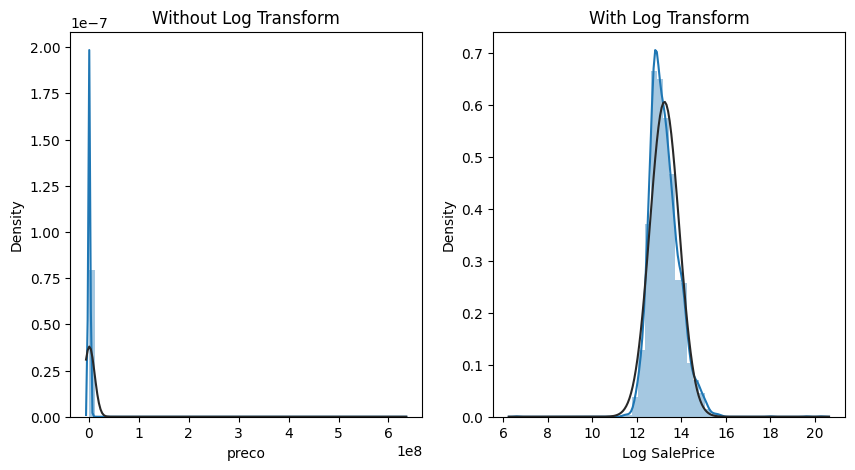

In [35]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
sns.distplot(y_train, kde = True, fit = scipy.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1,2,2)
sns.distplot(np.log(y_train), kde = True, fit = scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

In [36]:
# log transformation
y_train_log = np.log(y_train)

## 3. Modelagem

### 3.1. Selecionar melhor modelo
Aqui fiz um loop ao longo dos modelos que escolhi para testar, e calculei a raiz quadrada do erro percentual quadrático médio (RMSPE) de cada um através de validação cruzada. 

A função para calcular o RMSPE foi implementada à parte. Aqui, como o parâmetro greater_is_better está em Falso, os modelos com os maiores valores são os que tiveram o melhor desempenho.

In [37]:
# Função para calcular RMSPE
def rmspe(y_true, y_pred):
    pct_error = (y_true - y_pred) / y_true
    pct_error[pct_error == np.inf] = 0  # Trata casos em que y_true é zero
    rmspe_score = np.sqrt(np.mean(pct_error**2))
    return rmspe_score

# Cria um scorer personalizado usando a função rmspe
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

In [38]:
# Lista de modelos a serem testados
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regression': SVR(),
    'KNeighbors Regressor': KNeighborsRegressor(),
    'Bayesian Ridge': BayesianRidge(),
    'Orthogonal Matching Pursuit': OrthogonalMatchingPursuit(),
    'XGB Regressor': XGBRegressor()
}

In [39]:
best_model = (-np.inf, 'none')

# Loop através dos modelos e imprime o desempenho usando validação cruzada
for model_name, model in models.items():   
    # Calcule a pontuação RMSPE usando validação cruzada
    cv_scores = cross_val_score(model, X_train, y_train_log, cv=5, scoring=rmspe_scorer)
    avg_score = np.mean(cv_scores)
    print(f"{model_name} - Mean RMSPE: {avg_score:.4f}")

    if best_model[0] < avg_score:
        best_model = (avg_score, model_name)

print(f"\nBest Performance: {best_model[1]} - Mean RMSPE: {best_model[0]:.4f}")

Linear Regression - Mean RMSPE: -3660498004.3276
Ridge Regression - Mean RMSPE: -0.0250
Lasso Regression - Mean RMSPE: -0.0496
Elastic Net - Mean RMSPE: -0.0493
Decision Tree - Mean RMSPE: -0.0320
Random Forest - Mean RMSPE: -0.0244
Gradient Boosting - Mean RMSPE: -0.0242
Support Vector Regression - Mean RMSPE: -0.0234
KNeighbors Regressor - Mean RMSPE: -0.0251
Bayesian Ridge - Mean RMSPE: -0.0250
Orthogonal Matching Pursuit - Mean RMSPE: -0.0264
XGB Regressor - Mean RMSPE: -0.0234

Best Performance: Support Vector Regression - Mean RMSPE: -0.0234


### 3.2. Ajuste de hiperparâmetros
Tendo selecionado o melhor modelo na etapa anterior, otimizei os hiperparâmetros para reduzir o erro de validação cruzada. Para isso, usei pesquisa em grade (Grid Search).

In [40]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5, 1]
}

svr = SVR()

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring=rmspe_scorer, verbose=20000)
grid_search.fit(X_train, y_train_log)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5; 1/60] START C=0.1, epsilon=0.1, gamma=scale............................
[CV 1/5; 1/60] END C=0.1, epsilon=0.1, gamma=scale;, score=-0.022 total time=   1.1s
[CV 2/5; 1/60] START C=0.1, epsilon=0.1, gamma=scale............................
[CV 2/5; 1/60] END C=0.1, epsilon=0.1, gamma=scale;, score=-0.020 total time=   1.1s
[CV 3/5; 1/60] START C=0.1, epsilon=0.1, gamma=scale............................
[CV 3/5; 1/60] END C=0.1, epsilon=0.1, gamma=scale;, score=-0.023 total time=   1.2s
[CV 4/5; 1/60] START C=0.1, epsilon=0.1, gamma=scale............................
[CV 4/5; 1/60] END C=0.1, epsilon=0.1, gamma=scale;, score=-0.020 total time=   1.1s
[CV 5/5; 1/60] START C=0.1, epsilon=0.1, gamma=scale............................
[CV 5/5; 1/60] END C=0.1, epsilon=0.1, gamma=scale;, score=-0.036 total time=   1.1s
[CV 1/5; 2/60] START C=0.1, epsilon=0.1, gamma=auto.............................
[CV 1/5; 2/60] END C=0.1, e

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'epsilon': [0.1, 0.2, 0.5, 1],
                         'gamma': ['scale', 'auto', 0.1, 1, 10]},
             scoring=make_scorer(rmspe, greater_is_better=False),
             verbose=20000)

In [41]:
best_params = grid_search.best_params_
print(f"Best Hiperparameters: {best_params}")

Best Hiperparameters: {'C': 1, 'epsilon': 0.1, 'gamma': 0.1}


In [42]:
scores = cross_val_score(SVR(**best_params), X_train, y_train_log, cv=5, scoring=rmspe_scorer)
print(f"Support Vector Regression (Tuned) - Mean RMSPE: {np.mean(scores):.4f}")

Support Vector Regression (Tuned) - Mean RMSPE: -0.0231


### 3.3. Treinar o modelo
Treinando o modelo com os melhores hiperparâmetros encontrados no conjunto de treinamento completo.

In [44]:
# Treinando o modelo com os melhores hiperparâmetros no conjunto de treinamento completo
best_hr = SVR(**best_params)
best_hr.fit(X_train, y_train_log)

SVR(C=1, gamma=0.1)

### 3.4. Fazer previsões
Fazendo previsões no conjunto de testes usando o modelo que foi treinado. Temos que transformar o resultado de volta.

In [45]:
# Fazer previsões no conjunto de testes
best_hr_pred = best_hr.predict(X_test)

In [46]:
best_hr_pred = np.exp(best_hr_pred)

## 4. Arquivo de respostas
Aqui estou criando o arquivo de respostas com as previsões, que será enviado ao Kaggle.

In [47]:
kaggle = pd.DataFrame({'Id': id, 'preco': best_hr_pred})

In [48]:
kaggle.to_csv('ValorImovel.csv', index = False)

In [49]:
kaggle

,Id,preco
0,0,1.544234e+06
1,1,3.438719e+05
2,2,6.177511e+05
3,3,2.399002e+05
4,4,2.627923e+05
...,...,...
1995,1995,5.786414e+05
1996,1996,3.765762e+05
1997,1997,3.995613e+05
1998,1998,7.701245e+05
